# Project for predicting prices of a one room apartments in Kaliningrad, Russia

Data for this project has been parsed from russian real estate site CIAN. Data has information for 2816 apartments thas were currently on the market. For training model i chose Random Forest Regressor.

In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

## Import parsed data

In [130]:
# path for 3 parsed csv files
cian_msk = 'cian_msk_complete.csv'
cian_lenin = 'cian_lenin_complete.csv'
cian_center = 'cian_center_complete.csv'

# read csv
msk_data = pd.read_csv(cian_msk, encoding='windows-1251')
lenin_data = pd.read_csv(cian_lenin, encoding='windows-1251')
center_data = pd.read_csv(cian_center, encoding='windows-1251')

# adding 'district' feature
district_msk = 'moskovski'
district_center = 'central'
district_lenin = 'leninski'
center_data['District'] = district_center
lenin_data['District'] = district_lenin
msk_data['District'] = district_msk

# combine data in one dataset
whole_data = pd.concat([center_data, lenin_data, msk_data], axis=0,
                       ignore_index='True')

# drop feature which is not used for now (maybe will in the future)
whole_data = whole_data.drop(['Address'], axis=1)

# sample of a data
whole_data

,Area,RoomFloor,TopFloor,Price,RoomArea,KitchenArea,BuildDate,BathroomNum,BathroomType,BalconyNum,BalconyType,Repair,TypeofBuilding,TypeofMaterial,Heating,GasSupply,District
0,32.7,1,4,1550000,17.0,8.0,1937.0,1.0,совмещенный,NaN,NaN,Косметический,Кирпичный,NaN,NaN,NaN,central
1,32.6,1,3,1600000,16.3,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,central
2,35.5,3,5,1600000,16.8,9.4,1986.0,1.0,совмещенный,1.0,балкон,Косметический,NaN,NaN,NaN,NaN,central
3,36.1,5,5,1650000,17.6,13.2,1980.0,NaN,NaN,NaN,NaN,Косметический,NaN,NaN,NaN,NaN,central
4,30.0,2,2,1720000,15.5,7.0,1945.0,NaN,NaN,NaN,NaN,NaN,Кирпичный,Смешанные,Автономная котельная,Центральное,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,39.0,1,8,2500000,17.0,10.0,2016.0,1.0,совмещенный,1.0,лоджия,Косметический,NaN,NaN,NaN,NaN,moskovski
2812,41.0,1,7,2600000,NaN,NaN,2019.0,1.0,совмещенный,1.0,лоджия,Евроремонт,NaN,NaN,NaN,NaN,moskovski
2813,59.0,5,10,2600000,23.0,11.0,1982.0,1.0,раздельный,1.0,балкон,Косметический,Панельный,Железобетонные,Центральное,Центральное,moskovski
2814,38.0,3,7,2700000,NaN,NaN,2019.0,1.0,совмещенный,1.0,лоджия,Евроремонт,NaN,NaN,NaN,NaN,moskovski


### Price distribution between 3 districts

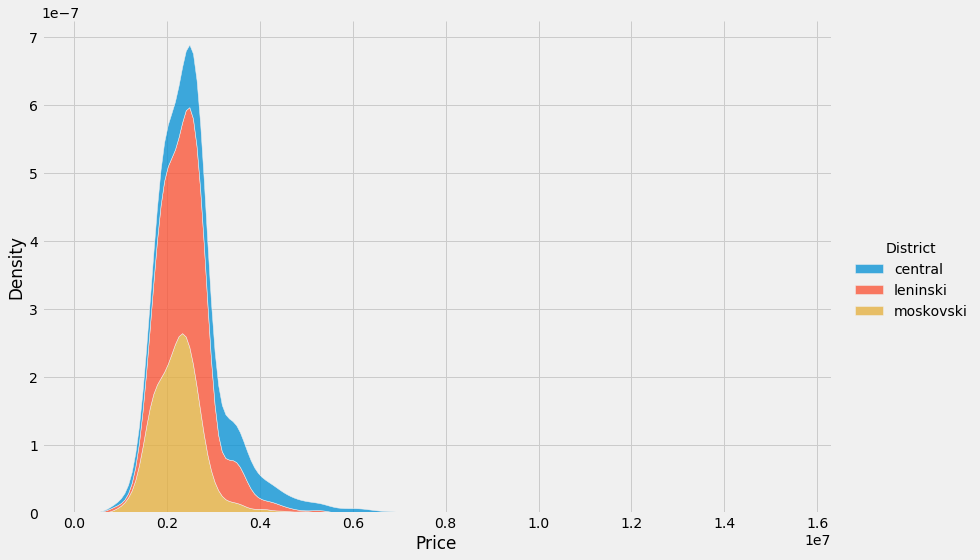

In [133]:
# Distribution of appartments by discrict
sns.displot(
    data=whole_data, kind='kde',
    x='Price', hue='District', multiple='stack',
    height=8, aspect=1.5)

## Baseline with fewer features and not tuned Random Forest Regressor

In [135]:
baseline_data_test = whole_data.copy()
baseline_y = baseline_data_test['Price']

# 'Area','RoomFloor','TopFloor' features dont have missing values
# so it's a simple way to build baseline model from that features
baseline_X = baseline_data_test[['Area', 'RoomFloor', 'TopFloor']]

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    baseline_X, baseline_y, test_size=0.15, random_state=0)

forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(X_train_base, y_train_base)
forest_pred = forest_model.predict(X_val_base)
forest_mae = mae(y_val_base, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a baseline model is = ',
      100 - forest_mae*100/y_val_base.mean())

MAE of a prediction to validation set is =  344709.49739872495
The acuracy of a baseline model is =  86.4034936164196


# Prepocessing Data

In [140]:
def error_changer(pd_data, col_name, obj1, obj2, cor_len=4):
    '''
    changing wrong parsed objects if they have some symbols
    in common with correct objects, returns changed dataset

    pd_data - whole dataset in pd.DataFrame
    obj1 - first correct object name
    obj2 - second correct object name
    col_name - name of a column
    cor_len - lenght of symbols witch is enough to
    find all slightly wrong parsed objects
    '''
    cut_obj1 = obj1[0:cor_len]
    cut_obj2 = obj2[0:cor_len]

    for i in range(0, len(whole_data)):
        if whole_data[col_name].isnull().values[i] is True:
            if cut_obj1 in whole_data.loc[i, (col_name)]:
                whole_data.loc[i, (col_name)] = obj1
            elif cut_obj2 in whole_data.loc[i, (col_name)]:
                whole_data.loc[i, (col_name)] = obj2

    return pd_data

In [142]:
# change feature values with error in parsing
whole_data = error_changer(whole_data, 'BathroomType',
                           'совмещенный', 'раздельный')
whole_data = error_changer(whole_data, 'BalconyType',
                           'балкон', 'лоджия')
whole_data = error_changer(whole_data, 'TypeofBuilding',
                           'Монолитный', 'Кирпичный')

In [144]:
# take a look at how much missing data we have
mis_vals = whole_data.isnull().sum()

print('Missing data in %:\n',
      100*round(mis_vals/len(whole_data), 3))

Missing data in %:
 Area               0.0
RoomFloor          0.0
TopFloor           0.0
Price              0.0
RoomArea          53.3
KitchenArea       50.4
BuildDate         22.3
BathroomNum       25.7
BathroomType      25.7
BalconyNum        32.5
BalconyType       32.5
Repair             9.8
TypeofBuilding    41.8
TypeofMaterial    80.0
Heating           80.5
GasSupply         83.1
District           0.0
dtype: float64


## Get rid of 3 least filled features - 'part_data'

In [147]:
# copy original data
part_data = whole_data.copy()

# drop least filled features
part_data = part_data.drop([
    'TypeofMaterial', 'Heating', 'GasSupply'], axis=1)

# create list with 'object' type features
obj_types = (part_data.dtypes == 'object')
object_cols = list(obj_types[obj_types].index)

# adding features to show what was missing
cols_with_missing = [col for col in part_data.columns
                     if part_data[col].isnull().any()]
for col in cols_with_missing:
    part_data[col+'_IsMissing'] = part_data[col].isnull()

# imputation categorical and non categorical data
median_imputer = pd.Series([
    part_data[dt].value_counts().index[0]
    if part_data[dt].dtype == 'object'
    else part_data[dt].median() for dt in part_data],
    index=part_data.columns)

part_data = part_data.fillna(median_imputer)

# set OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_ft = pd.DataFrame(oh_encoder.fit_transform(
    part_data[object_cols]))

# One-hot encoding removed index; put it back
oh_cols_ft.index = part_data.index

# Set names for encoded features
feature_names = oh_encoder.get_feature_names()
oh_cols_ft.columns = feature_names

# Remove categorical columns (will replace with one-hot encoding)
part_data = part_data.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
part_data = pd.concat([part_data, oh_cols_ft], axis=1)

# show final list of columns
part_data.columns

Index(['Area', 'RoomFloor', 'TopFloor', 'Price', 'RoomArea', 'KitchenArea',
       'BuildDate', 'BathroomNum', 'BalconyNum', 'RoomArea_IsMissing',
       'KitchenArea_IsMissing', 'BuildDate_IsMissing', 'BathroomNum_IsMissing',
       'BathroomType_IsMissing', 'BalconyNum_IsMissing',
       'BalconyType_IsMissing', 'Repair_IsMissing', 'TypeofBuilding_IsMissing',
       'x0_ раздельный', 'x0_ раздельных', 'x0_ совмещенный',
       'x0_ совмещенный, ', 'x0_ совмещенных', 'x1_ балкон', 'x1_ балкон, ',
       'x1_ балкона', 'x1_ лоджии', 'x1_ лоджия', 'x2_Без ремонта',
       'x2_Дизайнерский', 'x2_Евроремонт', 'x2_Косметический', 'x3_Блочный',
       'x3_Кирпичный', 'x3_Монолитно кирпичный', 'x3_Монолитный',
       'x3_Панельный', 'x3_Сталинский', 'x4_central', 'x4_leninski',
       'x4_moskovski'],
      dtype='object')

## Create new 'decade' categorical feature - 'dec_part_data'

In [151]:
# copy part data
dec_part_data = part_data.copy()

# create decade feature with 6 categories
dec_part_data['Decade'] = 'empt'
for i in range(0, len(dec_part_data['BuildDate'])):
    if dec_part_data.loc[i, ('BuildDate')] in range(1937, 1951):
        dec_part_data.loc[i, ('Decade')] = '37-50'
    elif dec_part_data.loc[i, ('BuildDate')] in range(1951, 1971):
        dec_part_data.loc[i, ('Decade')] = '51-70'
    elif dec_part_data.loc[i, ('BuildDate')] in range(1971, 1991):
        dec_part_data.loc[i, ('Decade')] = '71-90'
    elif dec_part_data.loc[i, ('BuildDate')] in range(1991, 2001):
        dec_part_data.loc[i, ('Decade')] = '91-00'
    elif dec_part_data.loc[i, ('BuildDate')] in range(2001, 2011):
        dec_part_data.loc[i, ('Decade')] = '01-10'
    elif dec_part_data.loc[i, ('BuildDate')] in range(2011, 2021):
        dec_part_data.loc[i, ('Decade')] = '11-20'

# set OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_ft = pd.DataFrame(oh_encoder.fit_transform(
    dec_part_data['Decade'].values.reshape(-1, 1)))

# One-hot encoding removed index; put it back
oh_cols_ft.index = dec_part_data.index

# Set names for encoded features
feature_names = oh_encoder.get_feature_names()
oh_cols_ft.columns = feature_names

# Remove categorical columns (will replace with one-hot encoding)
dec_part_data = dec_part_data.drop(['Decade'], axis=1)

# Add one-hot encoded columns to numerical features
dec_part_data = pd.concat([dec_part_data, oh_cols_ft], axis=1)

# show final list of columns
dec_part_data.columns

Index(['Area', 'RoomFloor', 'TopFloor', 'Price', 'RoomArea', 'KitchenArea',
       'BuildDate', 'BathroomNum', 'BalconyNum', 'RoomArea_IsMissing',
       'KitchenArea_IsMissing', 'BuildDate_IsMissing', 'BathroomNum_IsMissing',
       'BathroomType_IsMissing', 'BalconyNum_IsMissing',
       'BalconyType_IsMissing', 'Repair_IsMissing', 'TypeofBuilding_IsMissing',
       'x0_ раздельный', 'x0_ раздельных', 'x0_ совмещенный',
       'x0_ совмещенный, ', 'x0_ совмещенных', 'x1_ балкон', 'x1_ балкон, ',
       'x1_ балкона', 'x1_ лоджии', 'x1_ лоджия', 'x2_Без ремонта',
       'x2_Дизайнерский', 'x2_Евроремонт', 'x2_Косметический', 'x3_Блочный',
       'x3_Кирпичный', 'x3_Монолитно кирпичный', 'x3_Монолитный',
       'x3_Панельный', 'x3_Сталинский', 'x4_central', 'x4_leninski',
       'x4_moskovski', 'x0_01-10', 'x0_11-20', 'x0_37-50', 'x0_51-70',
       'x0_71-90', 'x0_91-00'],
      dtype='object')

## Standard features  - 'whole_data'

In [154]:
# create list with object type features
obj_types = (whole_data.dtypes == 'object')
object_cols = list(obj_types[obj_types].index)

# adding features to show what was missing
cols_with_missing = [col for col in whole_data.columns
                     if whole_data[col].isnull().any()]
for col in cols_with_missing:
    whole_data[col+'_IsMissing'] = whole_data[col].isnull()

# imputation categorical and non categorical data
median_imputer = pd.Series([
    whole_data[dt].value_counts().index[0]
    if whole_data[dt].dtype == 'object'
    else whole_data[dt].median() for dt in whole_data],
    index=whole_data.columns)

whole_data = whole_data.fillna(median_imputer)

# set OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_ft = pd.DataFrame(
    oh_encoder.fit_transform(whole_data[object_cols]))

# One-hot encoding removed index; put it back
oh_cols_ft.index = whole_data.index

# Set names for encoded features
feature_names = oh_encoder.get_feature_names()
oh_cols_ft.columns = feature_names

# Remove categorical columns (will replace with one-hot encoding)
whole_data = whole_data.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
whole_data = pd.concat([whole_data, oh_cols_ft], axis=1)

# show final list of columns
whole_data.columns

Index(['Area', 'RoomFloor', 'TopFloor', 'Price', 'RoomArea', 'KitchenArea',
       'BuildDate', 'BathroomNum', 'BalconyNum', 'RoomArea_IsMissing',
       'KitchenArea_IsMissing', 'BuildDate_IsMissing', 'BathroomNum_IsMissing',
       'BathroomType_IsMissing', 'BalconyNum_IsMissing',
       'BalconyType_IsMissing', 'Repair_IsMissing', 'TypeofBuilding_IsMissing',
       'TypeofMaterial_IsMissing', 'Heating_IsMissing', 'GasSupply_IsMissing',
       'x0_ раздельный', 'x0_ раздельных', 'x0_ совмещенный',
       'x0_ совмещенный, ', 'x0_ совмещенных', 'x1_ балкон', 'x1_ балкон, ',
       'x1_ балкона', 'x1_ лоджии', 'x1_ лоджия', 'x2_Без ремонта',
       'x2_Дизайнерский', 'x2_Евроремонт', 'x2_Косметический', 'x3_Блочный',
       'x3_Кирпичный', 'x3_Монолитно кирпичный', 'x3_Монолитный',
       'x3_Панельный', 'x3_Сталинский', 'x4_Деревянные', 'x4_Железобетонные',
       'x4_Смешанные', 'x5_Автономная котельная',
       'x5_Котел/Квартирное отопление', 'x5_Нет', 'x5_Центральное',
       'x6_

## Standard features plus 'decade' - 'all_data'

In [157]:
all_data = whole_data.copy()
all_data['Decade'] = 'empt'
for i in range(0, len(all_data['BuildDate'])):
    if all_data.loc[i, ('BuildDate')] in range(1937, 1951):
        all_data.loc[i, ('Decade')] = '37-50'
    elif all_data.loc[i, ('BuildDate')] in range(1951, 1971):
        all_data.loc[i, ('Decade')] = '51-70'
    elif all_data.loc[i, ('BuildDate')] in range(1971, 1991):
        all_data.loc[i, ('Decade')] = '71-90'
    elif all_data.loc[i, ('BuildDate')] in range(1991, 2001):
        all_data.loc[i, ('Decade')] = '91-00'
    elif all_data.loc[i, ('BuildDate')] in range(2001, 2011):
        all_data.loc[i, ('Decade')] = '01-10'
    elif all_data.loc[i, ('BuildDate')] in range(2011, 2021):
        all_data.loc[i, ('Decade')] = '11-20'

# set OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_ft = pd.DataFrame(oh_encoder.fit_transform(
    all_data['Decade'].values.reshape(-1, 1)))

# One-hot encoding removed index; put it back
oh_cols_ft.index = all_data.index

# Set names for encoded features
feature_names = oh_encoder.get_feature_names()
oh_cols_ft.columns = feature_names

# Remove categorical columns (will replace with one-hot encoding)
all_data = all_data.drop(['Decade'], axis=1)

# Add one-hot encoded columns to numerical features
all_data = pd.concat([all_data, oh_cols_ft], axis=1)

# show final list of columns
all_data.columns

Index(['Area', 'RoomFloor', 'TopFloor', 'Price', 'RoomArea', 'KitchenArea',
       'BuildDate', 'BathroomNum', 'BalconyNum', 'RoomArea_IsMissing',
       'KitchenArea_IsMissing', 'BuildDate_IsMissing', 'BathroomNum_IsMissing',
       'BathroomType_IsMissing', 'BalconyNum_IsMissing',
       'BalconyType_IsMissing', 'Repair_IsMissing', 'TypeofBuilding_IsMissing',
       'TypeofMaterial_IsMissing', 'Heating_IsMissing', 'GasSupply_IsMissing',
       'x0_ раздельный', 'x0_ раздельных', 'x0_ совмещенный',
       'x0_ совмещенный, ', 'x0_ совмещенных', 'x1_ балкон', 'x1_ балкон, ',
       'x1_ балкона', 'x1_ лоджии', 'x1_ лоджия', 'x2_Без ремонта',
       'x2_Дизайнерский', 'x2_Евроремонт', 'x2_Косметический', 'x3_Блочный',
       'x3_Кирпичный', 'x3_Монолитно кирпичный', 'x3_Монолитный',
       'x3_Панельный', 'x3_Сталинский', 'x4_Деревянные', 'x4_Железобетонные',
       'x4_Смешанные', 'x5_Автономная котельная',
       'x5_Котел/Квартирное отопление', 'x5_Нет', 'x5_Центральное',
       'x6_

## 'All_data' without 'BuildDate' feature - 'all_data_wt_BD'

In [159]:
all_data_wt_BD = all_data.copy()
all_data_wt_BD = all_data_wt_BD.drop('BuildDate', axis=1)
all_data_wt_BD.columns

Index(['Area', 'RoomFloor', 'TopFloor', 'Price', 'RoomArea', 'KitchenArea',
       'BathroomNum', 'BalconyNum', 'RoomArea_IsMissing',
       'KitchenArea_IsMissing', 'BuildDate_IsMissing', 'BathroomNum_IsMissing',
       'BathroomType_IsMissing', 'BalconyNum_IsMissing',
       'BalconyType_IsMissing', 'Repair_IsMissing', 'TypeofBuilding_IsMissing',
       'TypeofMaterial_IsMissing', 'Heating_IsMissing', 'GasSupply_IsMissing',
       'x0_ раздельный', 'x0_ раздельных', 'x0_ совмещенный',
       'x0_ совмещенный, ', 'x0_ совмещенных', 'x1_ балкон', 'x1_ балкон, ',
       'x1_ балкона', 'x1_ лоджии', 'x1_ лоджия', 'x2_Без ремонта',
       'x2_Дизайнерский', 'x2_Евроремонт', 'x2_Косметический', 'x3_Блочный',
       'x3_Кирпичный', 'x3_Монолитно кирпичный', 'x3_Монолитный',
       'x3_Панельный', 'x3_Сталинский', 'x4_Деревянные', 'x4_Железобетонные',
       'x4_Смешанные', 'x5_Автономная котельная',
       'x5_Котел/Квартирное отопление', 'x5_Нет', 'x5_Центральное',
       'x6_Автономное', 

#  Random Forest Regressor hyperparameter tuning

## whole_data (standard features)

In [161]:
y = whole_data.Price
X = whole_data.drop(['Price'], axis=1)

# divide data into train and test groups
# then divide train into train and validation groups
train_X_wd, test_X_wd, train_y_wd, test_y_wd = train_test_split(
    X, y, test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(
    train_X_wd, train_y_wd, test_size=0.177, random_state=0)

### Randomized search CV is used only once because of a long run time
### and results let us get all needed hyperparameters besides n_estimatiors

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 200 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=200, cv=3, verbose=3, random_state=0,
                               n_jobs=-1)

# Fit the random search model
rf_random.fit(train_X, train_y)

In [24]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

### For n_estimators hyperparameter tuning its more effective to use Grid Search CV

In [78]:
# Create the parameter grid based on the results of random search 
n_estimators = [int(x) for x in np.linspace(100, 1000, 46)]
param_grid = {
    'bootstrap': [False],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': n_estimators
}

# Create a based model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_features': ['sqrt'],
      

In [79]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 820}

In [163]:
best_estimator_wd = grid_search.best_estimator_
forest_model = RandomForestRegressor(random_state=0)
forest_model.set_params(**grid_search.best_params_)
forest_model.fit(train_X, train_y)
forest_pred = forest_model.predict(val_X)
forest_mae = mae(val_y, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a model with standard features is = ',
      100 - forest_mae*100/val_y.mean())

MAE of a prediction to validation set is =  259536.20340537163
The acuracy of a model with standard features is =  89.74388385745743


## part_data (data without 3 most empty features)

In [81]:
y = part_data.Price
X = part_data.drop(['Price'], axis=1)

# divide data into train and test groups
# then divide train into train and validation groups
train_X_pd, test_X_pd, train_y_pd, test_y_pd = train_test_split(
    X, y, test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(
    train_X_pd, train_y_pd, test_size=0.177, random_state=0)

In [82]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 46)]
}

# Create a based model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_features': ['sqrt'],
      

In [83]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 660}

In [164]:
best_estimator_pd = grid_search.best_estimator_
forest_model = RandomForestRegressor(random_state=0)
forest_model.set_params(**grid_search.best_params_)
forest_model.fit(train_X, train_y)
forest_pred = forest_model.predict(val_X)
forest_mae = mae(val_y, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a model without 3 most empty features is = ',
      100 - forest_mae*100/val_y.mean())

MAE of a prediction to validation set is =  259536.20340537163
The acuracy of a model without 3 most empty features is =  89.74388385745743


## dec_part_data (new 'decade' feature with 3 most empty features out of data)

In [85]:
y = dec_part_data.Price
X = dec_part_data.drop(['Price'], axis=1)

# divide data into train and test groups
# then divide train into train and validation groups
train_X_dpd, test_X_dpd, train_y_dpd, test_y_dpd = train_test_split(
    X, y, test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(
    train_X_dpd, train_y_dpd, test_size=0.177, random_state=0)

In [86]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 46)]
}

# Create a based model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_features': ['sqrt'],
      

In [87]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 660}

In [88]:
best_estimator_dpd = grid_search.best_estimator_
forest_model = RandomForestRegressor(random_state=0)
forest_model.set_params(**grid_search.best_params_)
forest_model.fit(train_X, train_y)
forest_pred = forest_model.predict(val_X)
forest_mae = mae(val_y, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a model with new "decade" features is = ',
      100 - forest_mae*100/val_y.mean())

MAE of a prediction to validation set is =  258384.13853817826
The acuracy of a model with new "decade" features is =  89.78941011131585


## all_data (all features included)

In [89]:
y = all_data.Price
X = all_data.drop(['Price'], axis=1)

# divide data into train and test groups
# then divide train into train and validation groups
train_X_ad, test_X_ad, train_y_ad, test_y_ad = train_test_split(
    X, y, test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(
    train_X_ad, train_y_ad, test_size=0.177, random_state=0)

In [90]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 46)]
}

# Create a based model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_features': ['sqrt'],
      

In [91]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 180}

In [92]:
best_estimator_ad = grid_search.best_estimator_
forest_model = RandomForestRegressor(random_state=0)
forest_model.set_params(**grid_search.best_params_)
forest_model.fit(train_X, train_y)
forest_pred = forest_model.predict(val_X)
forest_mae = mae(val_y, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a model with all features is = ',
      100 - forest_mae*100/val_y.mean())

MAE of a prediction to validation set is =  259553.9768524758
The acuracy of a model with all features is =  89.74318150250517


## all_data_wt_BD (all features without 'BuildDate')

In [93]:
y = all_data_wt_BD.Price
X = all_data_wt_BD.drop(['Price'], axis=1)

# divide data into train and test groups
# then divide train into train and validation groups
train_X_adwt, test_X_adwt, train_y_adwt, test_y_adwt = train_test_split(
    X, y, test_size=0.15, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(
    train_X_adwt, train_y_adwt, test_size=0.177, random_state=0)

In [94]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 46)]
}

# Create a based model
rf = RandomForestRegressor(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_features': ['sqrt'],
      

In [95]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 840}

In [96]:
best_estimator_adwt = grid_search.best_estimator_
forest_model = RandomForestRegressor(random_state=0)
forest_model.set_params(**grid_search.best_params_)
forest_model.fit(train_X, train_y)
forest_pred = forest_model.predict(val_X)
forest_mae = mae(val_y, forest_pred)
print('MAE of a prediction to validation set is = ', forest_mae)
print('The acuracy of a model without "BuildDate" features is = ',
      100 - forest_mae*100/val_y.mean())

MAE of a prediction to validation set is =  261610.5659219506
The acuracy of a model without "BuildDate" features is =  89.66191108212736


# Comparison

In [166]:
def evaluate(model, test_X, test_y):
    model.random_state = 0
    predictions = model.predict(test_X)
    mae_error = mae(test_y, predictions)
    accuracy = 100 - 100 * mae_error / test_y.mean()
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f} rubles.'.format(mae_error))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

### Baseline

In [167]:
forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(X_train_base, y_train_base)
forest_pred = forest_model.predict(X_val_base)
mae_error = mae(y_val_base, forest_pred)
accuracy = 100 - 100 * mae_error / y_val_base.mean()
print('Model Performance')
print('Mean Absolute Error: {:0.4f} rubles.'.format(np.mean(mae_error)))
print('Accuracy = {:0.2f}%.'.format(accuracy))
baseline_results = {'model': 'baseline', 'time': np.nan, 'n_trees': np.nan,
                    'mae_error': mae_error, 'accuracy': accuracy,
                    'n_features': 3}

Model Performance
Mean Absolute Error: 344709.4974 rubles.
Accuracy = 86.40%.


### whole_data

In [99]:
wd_accuracy = evaluate(best_estimator_wd, test_X_wd, test_y_wd)

Model Performance
Mean Absolute Error: 255534.4801 rubles.
Accuracy = 89.92%.


### part_data

In [100]:
pd_accuracy = evaluate(best_estimator_pd, test_X_pd, test_y_pd)

Model Performance
Mean Absolute Error: 257343.1953 rubles.
Accuracy = 89.85%.


### dec_part_data

In [101]:
dpd_accuracy = evaluate(best_estimator_dpd, test_X_dpd, test_y_dpd)

Model Performance
Mean Absolute Error: 253416.9161 rubles.
Accuracy = 90.00%.


### all_data

In [102]:
ad_accuracy = evaluate(best_estimator_ad, test_X_ad, test_y_ad)

Model Performance
Mean Absolute Error: 257126.3027 rubles.
Accuracy = 89.86%.


### all_data_wt_BD

In [103]:
adwt_accuracy = evaluate(best_estimator_adwt, test_X_adwt, test_y_adwt)

Model Performance
Mean Absolute Error: 257928.6159 rubles.
Accuracy = 89.83%.


In [104]:
# Time used for evaluating model run times
import time

In [169]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]

    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))

        end_time = time.time()
        run_times.append(end_time - start_time)

    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis=0)

    # Calculate performance metrics
    mae_error = mae(y_test, predictions)
    accuracy = 100 - 100 * mae_error / y_test.mean()

    # Return results in a dictionary
    results = {'time': run_time, 'mae_error': mae_error, 'accuracy': accuracy,
               'n_trees': n_trees, 'n_features': n_features}

    return results

2:1: E302 expected 2 blank lines, found 0


In [106]:
wd_results = evaluate_model(
    best_estimator_wd, train_X_wd, train_y_wd, test_X_wd, test_y_wd)
wd_results['model'] = 'wd_results'

In [107]:
pd_results = evaluate_model(
    best_estimator_pd, train_X_pd, train_y_pd, test_X_pd, test_y_pd)
pd_results['model'] = 'pd_results'

In [108]:
dpd_results = evaluate_model(
    best_estimator_dpd, train_X_dpd, train_y_dpd, test_X_dpd, test_y_dpd)
dpd_results['model'] = 'dpd_results'

In [109]:
ad_results = evaluate_model(
    best_estimator_ad, train_X_ad, train_y_ad, test_X_ad, test_y_ad)
ad_results['model'] = 'ad_results'

In [110]:
adwt_results = evaluate_model(
    best_estimator_adwt, train_X_adwt, train_y_adwt, test_X_adwt, test_y_adwt)
adwt_results['model'] = 'adwt_results'

In [173]:
comparison = {'model': [baseline_results['model'],
                        wd_results['model']],
              'accuracy': [round(baseline_results['accuracy'], 3),
                           round(wd_results['accuracy'], 3)],
              'mae_error': [round(baseline_results['mae_error'], 3),
                            round(wd_results['mae_error'], 3)],
              'n_features': [baseline_results['n_features'],
                             wd_results['n_features']],
              'n_trees': [baseline_results['n_trees'],
                          int(wd_results['n_trees'])],
              'time': [round(baseline_results['time'], 4),
                       round(wd_results['time'], 4)]}

for model in [dpd_results, ad_results, adwt_results, pd_results]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['mae_error'].append(round(model['mae_error'], 3))
    comparison['model'].append(model['model'])
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))

In [175]:
comparison = pd.DataFrame.from_dict(comparison, orient='columns')

In [176]:
comparison

,model,accuracy,mae_error,n_features,n_trees,time
0,baseline,86.403,344709.497,3,NaN,NaN
1,wd_results,90.196,248569.478,52,820.0,5.4862
2,dpd_results,90.247,247253.953,46,660.0,4.0628
3,ad_results,90.366,244239.983,58,180.0,1.1670
4,adwt_results,90.120,250475.951,57,840.0,5.2660
5,pd_results,90.221,247932.998,40,660.0,4.1919


# Plotting

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

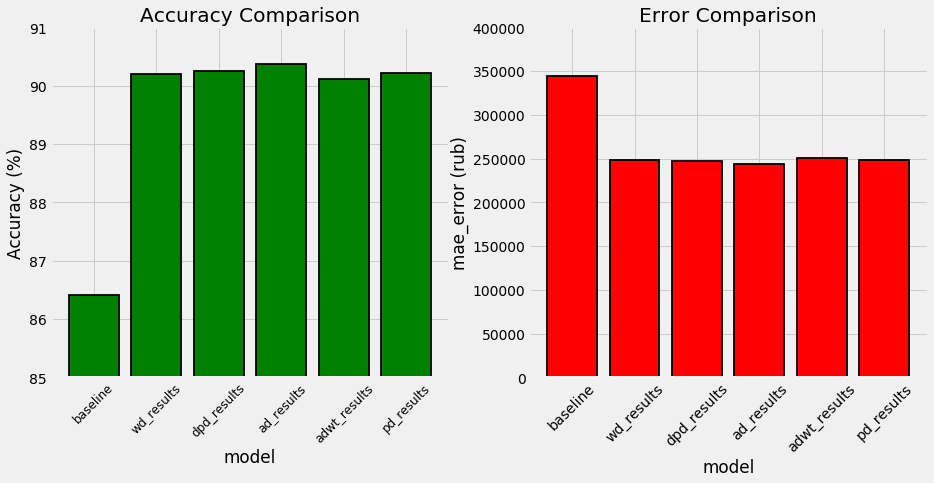

In [182]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(14, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['accuracy'],
        color='g', edgecolor='k', linewidth=1.8)
plt.xticks(xvalues, comparison['model'], rotation=45, fontsize=12)
plt.ylim(ymin=85, ymax=91)
plt.xlabel('model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')

plt.subplot(122)
plt.bar(xvalues, comparison['mae_error'],
        color='r', edgecolor='k', linewidth=1.8)
plt.xticks(xvalues, comparison['model'], rotation=45)
plt.ylim(ymin=0, ymax=4e5)
plt.xlabel('model')
plt.ylabel('mae_error (rub)')
plt.title('Error Comparison')
plt.show()

# In conclusion

Our results shows that new feature 'decade' improving performance of the model and 3 most empty features slightly decreasing it. But, after all, the most effective way in our case is to use all features. The differences between any model performances is not so impressive compared to increased performance from baseline. This increase from baseline performance let us save 100 000 rubles on the average.